In [1]:
using Random, Distributions
using DataFrames
using LinearAlgebra
using PDMats
Random.seed!(0)
using Plots
nothing

In [15]:
n_data = 200
n_state = 2
n_params = 2
T_threshold = 100

ut = rand(Distributions.Normal(0,1),n_data+1)
#一次遅れ系のARモデル
params = [0.4 0.6; 0.9 1.5]
#print(params[1,:]'*vcat(yt[1],ut[2]))

yt = zeros(n_data+1)
cluster = zeros(n_data+1)
for t=2:n_data+1
    if t < T_threshold
        state = 1
        noise = rand(Distributions.Normal(0,1),1)/16
    else
        state = 2
        noise = rand(Distributions.Normal(0,1),1)/2
    end
    cluster[t] = state
    #print(vcat(yt[t-1],ut[t]))
    #print(params[state,:]'*vcat(yt[t-1],ut[t]))
    yt[t] = params[state,:]'*vcat(yt[t-1],ut[t])# + noise[1]
end


label = zeros(n_data)
label[T_threshold:end] .+= 1
#color = np.where(label==1,"b","r")
#plt.legend()

X1 = vcat([0],yt[1:end-1])
X2 = ut[1:end]
X = hcat(X1,X2)
y = yt[1:end]
#rand_id = np.random.permutation(np.arange(n_data))
print(X[1:5,1],y[1:5])
plot(y)
#plt.savefig(r"C:\Users\GotoRei\Desktop\Tex\Research\DPMMandPWA\figure\ARMA.png")
length(y)

[0.0, 0.0, 0.4970480897400215, -0.012985204284349156, -0.0861064048720527][0.0, 0.4970480897400215, -0.012985204284349156, -0.0861064048720527, 0.31752768283104477]

201

In [2]:
const ε_default = 1e-6

"""
実対称行列を固有値が ε 以上の実対称行列に補正
"""
function corrected_PDMat(K)
    K = Symmetric(K)
    m = minimum(eigen(K).values)
    if m < ε
        K += (2max(0, -m) + ε)*I
    end
    Σ = PDMat(K)
end

corrected_PDMat

In [3]:
function sampler_θ_new(μ,Σ_inv)
    Σ = inv(Σ_inv)
    Σ = corrected_PDMat(Σ)
    vec(rand(Distributions.MvNormal(μ, Σ), 1))
end

sampler_θ_new (generic function with 1 method)

In [4]:
function sampler_σ_new(n_0,τ)
    rand(Distributions.InverseGamma(n_0/2, τ/2), 1)
end

sampler_σ_new (generic function with 1 method)

In [5]:
function sampler_θ_k(X_k,y_k,Σ_inv,σ_k,μ)
    Σ_k = inv(X_k'*X_k/(σ_k)^2 + Σ_inv)
    Σ_k = corrected_PDMat(Σ_k)
    μ_k = vec(Σ_k*(sum(y_k.*X_k/(σ_k)^2, dims=1)' + Σ_inv*μ))#mu(2,1)
    vec(rand(Distributions.MvNormal(μ_k, Σ_k), 1))
end

sampler_θ_k (generic function with 1 method)

In [6]:
function sampler_σ_k(X_k,y_k,τ,θ_k,n_p)
    τ_k = τ + sum((y_k - X_k*θ_k).^2)
    rand(Distributions.InverseGamma(n_p/2, τ_k/2),1)[1]^(1/2)
end

sampler_σ_k (generic function with 1 method)

In [7]:
function sampler_μ(K_p,Σ_inv,V_0,θ,μ_0)
    V_p = inv(K_p*Σ_inv + inv(V_0))
    V_p = corrected_PDMat(V_p)
    μ_p = vec(V_p*(Σ_inv*sum(θ,dims=2) + inv(V_0)*μ_0))
    rand(Distributions.MvNormal(μ_p, V_p), 1)
end

sampler_μ (generic function with 1 method)

In [8]:
function sampler_Σ_inv(ν_0,K_p,Σ_0,θ,μ)
    ν_p = ν_0 + K_p
    Σ_p = inv(inv(Σ_0) + (θ .- μ)*(θ .- μ)' + 0*E)
    Σ_p = corrected_PDMat(Σ_p)
    rand(Distributions.Wishart(ν_p, Σ_p),1)
end

sampler_Σ_inv (generic function with 1 method)

In [9]:
function sampler_τ(m_0,n_0,K_p,τ_0,σ)
    m_p = m_0 + n_0*K_p
    τ_p = τ_0 + sum((σ).^(-2))
    rand(Distributions.Gamma(m_p/2, τ_p/2),1)
end

sampler_τ (generic function with 1 method)

In [10]:
function sampler_z(Xt,yt,t,z,nz,K_p,θ,σ,μ,Σ_inv,n_0,τ,alpha)
    #print(z[t])
    #println(z)
    nz[z[t]] -= 1
    #そのクラスに所属するデータがなくなったら
    if nz[z[t]] == 0
        θ = θ[:,setdiff(1:end,z[t])]
        σ = σ[setdiff(1:end,z[t])]
        nz = nz[setdiff(1:end,z[t])]
        z[z.>z[t]] .-= 1
        K_p -= 1
    end
    #print(alpha)
    #println(nz)
    nz = vcat(nz,alpha)
    θ_new = sampler_θ_new(μ,Σ_inv)
    σ_new = sampler_σ_new(n_0,τ)
    θ = hcat(θ,θ_new)
    σ = vcat(σ,σ_new)
    Lz = zeros(K_p+1)
    #print(K_p)
    #println(nz)
    for k=1:K_p+1
        Lz[k] = pdf(Distributions.Normal(yt,σ[k]),Xt'*θ[:,k])*nz[k]
    end
    Lz = Lz/sum(Lz)
    zt = rand(Distributions.Categorical(Lz))#Int64
    
    #新しいクラスに入った
    if zt == K_p+1
        nz[zt] = 1
        K_p += 1
    #すでにあるクラスに入った
    else
        nz[zt] += 1
        θ = θ[:,1:K_p]
        σ = σ[1:K_p]
        nz = nz[1:K_p]
    end
    
    z[t] = zt
    return z,nz,θ,σ,K_p
end

sampler_z (generic function with 1 method)

In [11]:
function choise_params(z,θ,var)
    θ = θ[:,cluster]
    σ = var[cluster]
    count = 0
    for k=1:max(cluster)+1
        if !(k in cluster)
            count += 1
        end
        z[z.==k] .= k-count
    end
    return z,θ,σ
end

choise_params (generic function with 1 method)

In [12]:
function sampling(X,y,sample,burn_in,alpha)
    #=
    X : (T,Dim)
    y : (T,1)
    sample : int
    burn_in : int
    alpha : float <= (0,1)??
    =#
    
    T,Dim = size(X)
    
    z = ones(Int8,T)
    nz = [T]
    n_0 = 1
    #平均の生成過程
    μ_0 = zeros(Dim)
    V_0 = E
    μ = vec(rand(Distributions.MvLogNormal(μ_0,V_0),1))
    #共分散の生成過程
    ν_0 = 2
    Σ_0 = E
    Σ_inv = rand(Distributions.Wishart(ν_0,Σ_0),1)[1]
    #精度の生成過程
    m_0 = 0.5
    τ_0 = 1
    τ = rand(Distributions.Gamma(m_0/2,τ_0/2),1)[1]
    
    #パラメータの生成過程
    #θ = rand(Distributions.MvNormal(μ,inv(Σ_inv)),1)
    #σ = rand(Distributions.InverseGamma(n_0/2,τ/2))
    θ = [0;0]
    σ = [1.0]
    θ_best = θ
    σ_best = σ
    z_best = z
    nz_best = nz
    
    K_p = 1
    
    θ_trace = zeros(sample,Dim,T)
    σ_trace = zeros(sample,T)
    z_trace = zeros(sample,T)
    K_p_trace = zeros(sample)
    percent = 0
    
    Log_Lz_old = 1e+10
    
    for i=1:sample
        if i%(sample/50) == 0
            println(i,"sampling...",percent,"%")
            percent += 2
        end
        
        Log_Lz_old = 0
        for t=1:T
            z,nz,θ,σ,K_p = sampler_z(X[t,:],y[t],t,z,nz,K_p,θ,σ,μ,Σ_inv,n_0,τ,alpha)
            Log_Lz_old += log(1)
        end
        
        for k=1:K_p
            flag = z.==k
            X_k = X[flag,:]
            y_k = y[flag]
            σ_k = σ[k]
            nk  = sum(flag)
            n_p = n_0 + nk
            θ[:,k] = sampler_θ_k(X_k,y_k,Σ_inv,σ_k,μ)
            σ[k] = sampler_σ_k(X_k,y_k,τ,θ[:,k],n_p)
        end
        #println("theta",θ)
        #println("σ",σ)
        #println("Σ",inv(Σ_inv))
        
        μ = vec(sampler_μ(K_p,Σ_inv,V_0,θ,μ_0))
        Σ_inv = sampler_Σ_inv(ν_0,K_p,Σ_0,θ,μ)[1]
        τ = vec(sampler_τ(m_0,n_0,K_p,τ_0,σ))[1]
        
        
        θ_trace[i,:,1:K_p] = θ
        σ_trace[i,1:K_p] = σ
        z_trace[i,:] = z
        K_p_trace[i] = K_p
    end
    return θ_trace[burn_in:sample,:,:], σ_trace[burn_in:sample,:], z_trace[burn_in:sample,:], K_p_trace[burn_in:sample]
    
end

sampling (generic function with 1 method)

In [16]:

global ε = 1e-6
global E = Matrix(I, Dim, Dim)
@time θ_trace, σ_trace, z_trace, K_p_trace = sampling(X,y,50000,20000,1.0)

1000sampling...0%
2000sampling...2%
3000sampling...4%
4000sampling...6%
5000sampling...8%
6000sampling...10%
7000sampling...12%
8000sampling...14%
9000sampling...16%
10000sampling...18%
11000sampling...20%
12000sampling...22%
13000sampling...24%
14000sampling...26%
15000sampling...28%
16000sampling...30%
17000sampling...32%
18000sampling...34%
19000sampling...36%
20000sampling...38%
21000sampling...40%
22000sampling...42%
23000sampling...44%
24000sampling...46%
25000sampling...48%
26000sampling...50%
27000sampling...52%
28000sampling...54%
29000sampling...56%
30000sampling...58%
31000sampling...60%
32000sampling...62%
33000sampling...64%
34000sampling...66%
35000sampling...68%
36000sampling...70%
37000sampling...72%
38000sampling...74%
39000sampling...76%
40000sampling...78%
41000sampling...80%
42000sampling...82%
43000sampling...84%
44000sampling...86%
45000sampling...88%
46000sampling...90%
47000sampling...92%
48000sampling...94%
49000sampling...96%
50000sampling...98%
 73.998808 sec

([0.9166862785796364 1.3726876101640981; 0.8962278032763974 1.4894005592031423; … ; 0.9141441030265155 1.339004955306395; 0.8921309652619699 1.372970309848465]

[0.6164098850746422 0.5463048076547976; 0.5373134323914069 0.5839070081276165; … ; 0.4926654388246137 0.6401226331203193; 0.39919415555793736 0.5917230591891072]

[1.4257939766637513 1.7985097791699505; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0]

...

[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0]

[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0]

[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], [0.2859695670750082 0.3937750781771574 … 0.0 0.0; 0.36282730486954456 0.47801180064822385 … 0.0 0.0; … ; 0.4271969639798277 0.38351918910007493 … 0.0 0.0; 0.32385281217722867 0.2807067050701345 … 0.0 0.0], [1.0 2.0 … 1.0 1.0; 2.0 2.0 … 1.0 1.0; … ; 2.0 2.0 … 1.0 1.0; 2.0 2.0 … 1.0 1.0], [3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0])

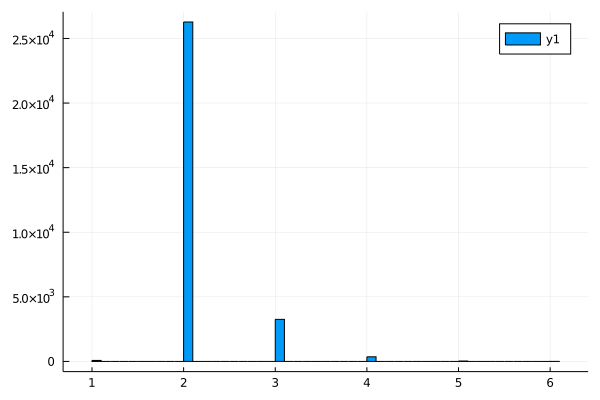

In [11124]:
histogram(K_p_trace)

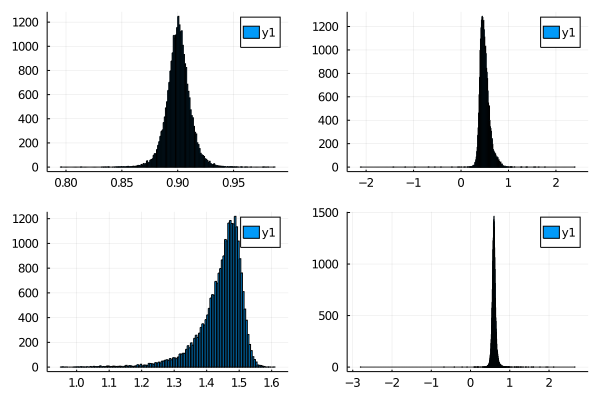

In [11126]:
θ_cls2 = θ_trace[K_p_trace.==2,:,1:2]


#θ_cls2 = θ_cls2[9001:end,:,:]
plot(
    histogram(θ_cls2[:,1,1]),
    histogram(θ_cls2[:,1,2]),
    histogram(θ_cls2[:,2,1]),
    histogram(θ_cls2[:,2,2]),
    layout=(2,2),  # 3行1列
    #link=:x  # x軸を共有
)

In [11128]:
θ_cls2 = round.(θ_cls2,digits=3)
W = zeros(2,2)
for j=1:2
    for i=1:2
        W[i,j] = mode(θ_cls2[:,i,j])
    end
end
W

2×2 Array{Float64,2}:
 0.9   0.486
 1.48  0.592

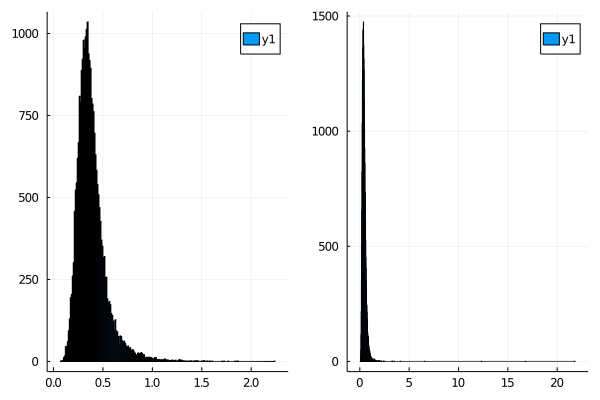

In [11178]:
σ_cls2 = σ_trace[K_p_trace.==2,1:2]

plot(
    histogram(σ_cls2[:,1]),
    histogram(σ_cls2[:,2]),
    layout=(1,2),  # 3行1列
    #link=:x  # x軸を共有
)

In [11181]:
θ_cls2 = round.(θ_cls2,digits=3)
sigmma = zeros(2)
for i=1:2
    sigmma[i] = mode(σ_cls2[:,i])
end
sigmma

2-element Array{Float64,1}:
 0.2768664744052455
 0.32411568655223205

In [11171]:
print(size(z_trace))
z_cls2 = z_trace[K_p_trace.==2,:]
print(size(z_cls2))
z_cls2_mode = zeros(201)
for t=1:201
    z_cls2_mode[t] = mode(z_cls2[:,t])
end

(30001, 201)(26275, 201)

In [11190]:
y_hat = zeros(2)
Lz = zeros(2)
c = zeros(201,2)
for t=1:201
    for k=1:2
        y_hat[k] = X[t,:]'*W[:,k]
        Lz[k] = pdf(Distributions.Normal(y_hat[k],sigmma[k]),y[t])
    end
    c[t,:] = Lz/sum(Lz)
end

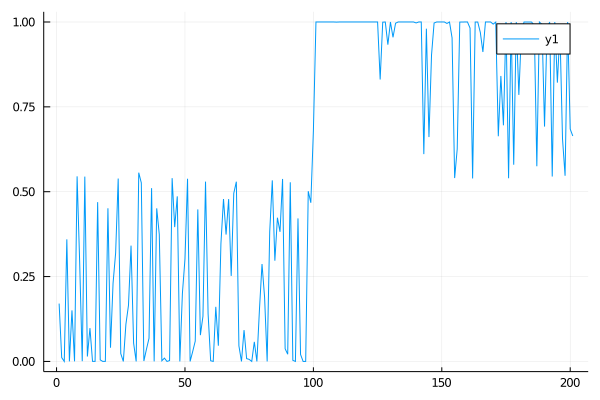

In [11191]:
plot(c[:,1])

In [11338]:
function msm_kalman_AR(X,y,c,θ,σ)
    n_cls = length(σ)
    P = 1*E
    A = E*0.99
    Z = ones(n_cls,n_cls)/n_cls
    Z_bar = zeros(n_cls,n_cls)
    mu = ones(n_cls)/n_cls
    
    for t=2:length(y)
        Z = A*Z
        P_hat = A*P*A
        g = P_hat*c[t,:] ./ ((c[t,:]'*P_hat*c[t,:])[1] + 1)
        
        
        for k=1:n_cls
            Z_bar[:,k] = Z[:,k] + (c[t,k] - (c[t-1,:]'*Z[:,k])[1])*g
            #Z_bar[:,k] = A*Z_bar[:,k]
        end
        
        
        #println(sum(Z_bar))
        Z_bar[Z_bar .< 0] .= 0
        Z = Z_bar./sum(Z_bar,dims=2)
        
        
        #P_hat = A*(E - g*c[t,:]') * P_hat * (E - g*c[t,:]')'*A'
        P = (E - g*c[t,:]') * P_hat
        
        #C = Z'*mu
    end
        
    return Z
end

msm_kalman_AR (generic function with 1 method)

In [11336]:
msm_kalman_AR(X,y,c,W,sigmma)

2×2 Array{Float64,2}:
 1.0          0.0
 3.23449e-11  1.0

[0.0, 0.0, -0.29764619020090477, -0.26650762192380784, 0.7531901925534918][0.0, -0.29764619020090477, -0.26650762192380784, 0.7531901925534918, -0.5595521319839256]

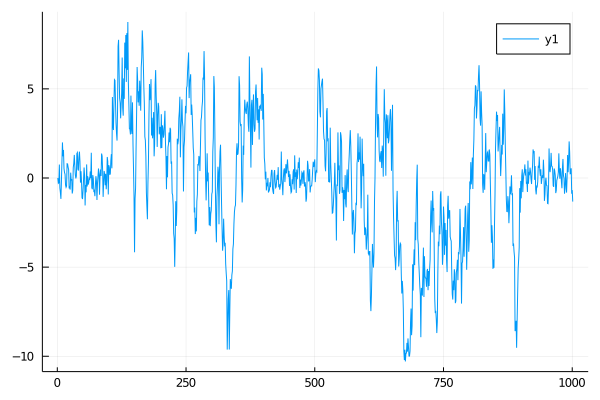

In [11284]:
n_data = 1000
n_state = 2
n_params = 2
T_threshold1 = 100
T_threshold2 = 400
T_threshold3 = 500
T_threshold4 = 900

ut = rand(Distributions.Normal(0,1),n_data+1)
#一次遅れ系のARモデル
params = [0.4 0.6; 0.9 1.5]
#print(params[1,:]'*vcat(yt[1],ut[2]))

yt = zeros(n_data+1)
cluster = zeros(n_data+1)
for t=2:n_data+1
    if t < T_threshold1 || T_threshold2<t<T_threshold3 || T_threshold4<t
        state = 1
        noise = rand(Distributions.Normal(0,1),1)/16
    else
        state = 2
        noise = rand(Distributions.Normal(0,1),1)/2
    end
    cluster[t] = state
    #print(vcat(yt[t-1],ut[t]))
    #print(params[state,:]'*vcat(yt[t-1],ut[t]))
    yt[t] = params[state,:]'*vcat(yt[t-1],ut[t])# + noise[1]
end


label = zeros(n_data)
label[T_threshold:end] .+= 1
#color = np.where(label==1,"b","r")
#plt.legend()

X1 = vcat([0],yt[1:end-1])
X2 = ut[1:end]
X = hcat(X1,X2)
y = yt[1:end]
#rand_id = np.random.permutation(np.arange(n_data))
print(X[1:5,1],y[1:5])
plot(y)
#plt.savefig(r"C:\Users\GotoRei\Desktop\Tex\Research\DPMMandPWA\figure\ARMA.png")
#length(y)

In [11286]:
y_hat = zeros(2)
Lz = zeros(2)
c = zeros(1001,2)
for t=1:1001
    for k=1:2
        y_hat[k] = X[t,:]'*W[:,k]
        Lz[k] = pdf(Distributions.Normal(y_hat[k],sigmma[k]),y[t])
    end
    c[t,:] = Lz/sum(Lz)
end

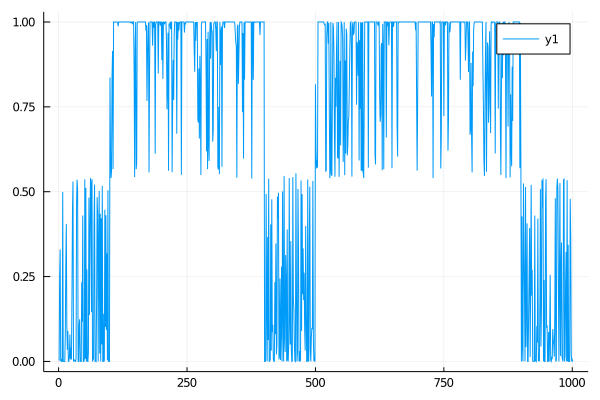

In [11287]:
plot(c[:,1])

In [11289]:
msm_kalman_AR(X,y,c,W,sigmma)

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0